# I am going to make a Image classification CNN model that is going to try and predict what a bunch of pictures represents. My dataset is the english language in sign language. So I have 26 classes A-Z. 

Lets start by picking a good dataset by inspecting the pictures in both the original state and the preprocessed state.

* Load the data
* Preprocess the data
* Plot the data

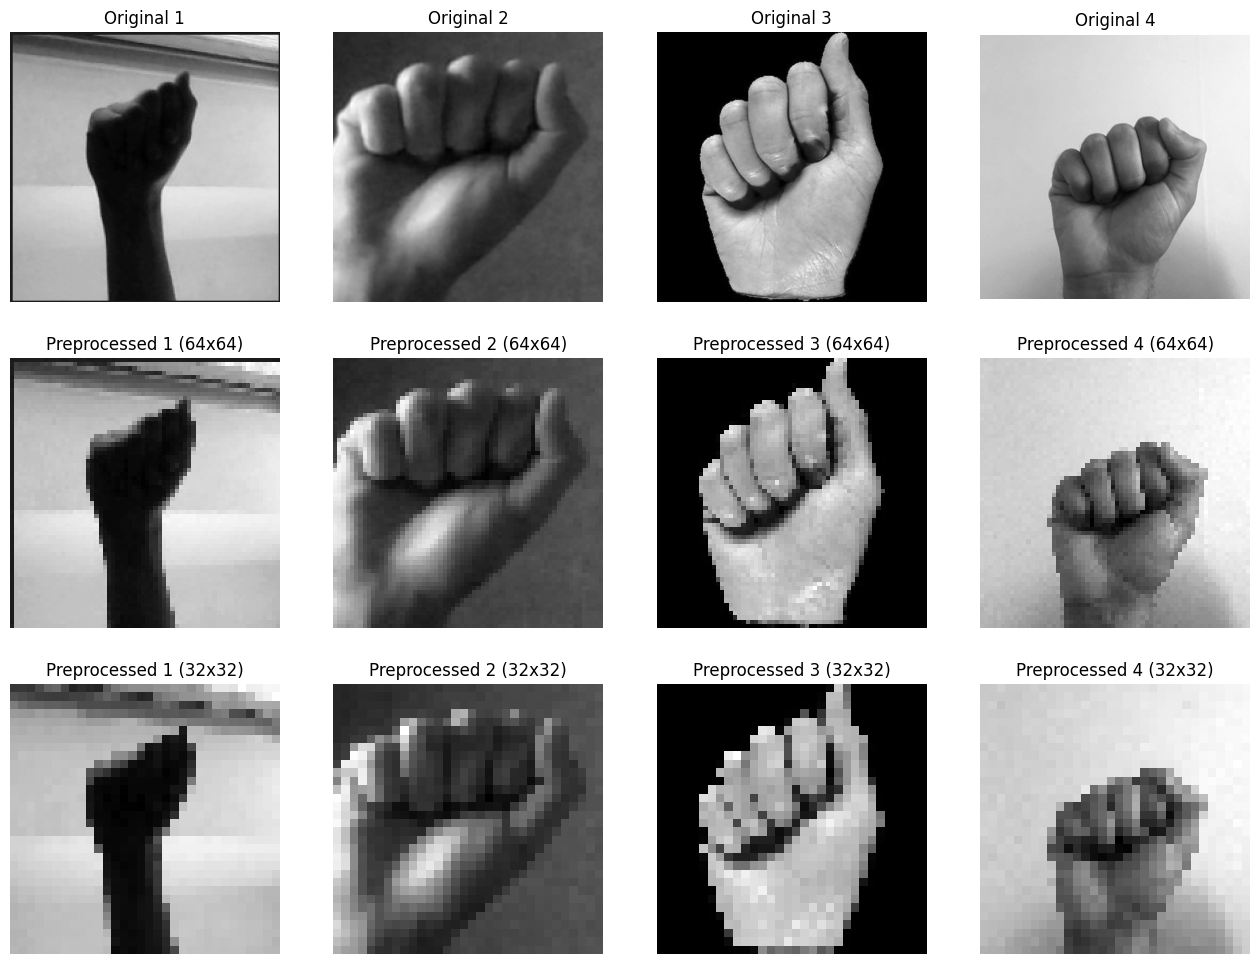

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

IMG_SIZE = (64, 64)
IMG_SIZE_SMALL = (32, 32)  


IMAGE_CHOICE_PATH = "Image_choice"

# Get a list of image file names in the directory
image_file_names = os.listdir(IMAGE_CHOICE_PATH)

# Create the full paths to the images
image_paths = [os.path.join(IMAGE_CHOICE_PATH, name) for name in image_file_names]

# Function to preprocess an image
def preprocess_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=target_size, color_mode='grayscale'  # Change color_mode to 'grayscale'
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0  # Normalize pixel values to the range [0, 1]
    return img

# Load and preprocess the original images
original_images = [tf.keras.preprocessing.image.load_img(path, color_mode='grayscale') for path in image_paths]
preprocessed_images_64 = [preprocess_image(path, target_size=IMG_SIZE) for path in image_paths]
preprocessed_images_32 = [preprocess_image(path, target_size=IMG_SIZE_SMALL) for path in image_paths]

# Create labels for the images
labels = ["Original 1", "Original 2", "Original 3", "Original 4",
          "Preprocessed 1 (64x64)", "Preprocessed 2 (64x64)", "Preprocessed 3 (64x64)", "Preprocessed 4 (64x64)",
          "Preprocessed 1 (32x32)", "Preprocessed 2 (32x32)", "Preprocessed 3 (32x32)", "Preprocessed 4 (32x32)"]

# Plot the images with labels
plt.figure(figsize=(16, 12))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    if i < 4:
        plt.imshow(original_images[i], cmap='gray')
    elif i < 8:
        plt.imshow(preprocessed_images_64[i - 4], cmap='gray')  
    else:
        plt.imshow(preprocessed_images_32[i - 8], cmap='gray')  
    plt.title(labels[i])
    plt.axis("off")

plt.show()


Ok so lets think about how the machine is going to understand these pictures. In order to get some good features out of our 
CNN we have to have smooth edges around our hand and a clean background. This is four different datasets. The 64x64 pictures 
have way smoother edges than the 32x32. The third dataset is the best because of the clean background and without the arm. 
I think the arm is unnecessary. However, the first dataset where the arm is visible has the most data and Ive gone through 
the pictures briefly and I think it could work. The fourth dataset is just 9 pictures I have taken myself trying to mirror 
the third dataset as much as possible. I will not use the second dataset. I am going to make predictions on my own pictures 
with my trained models. So I am going to build 2 models from scratch using the first dataset and then build a model to use 
the third dataset and then do the same thing but with transfer learning so Im going to use a pretrained model later.

Lets get to it!

# Preprocessing

I am going to use 64x64 pixels and only grayscale on the pictures to start with.  There is approximately 55 pictures per class in this dataset
and I am going to divide it into train, test and validation so the result will be 60% training data, 20% validation data and 20% test data. I will use a CNN network 
to look for features in all the classes and then I am going to have all these features as input to my classification layers..

In [151]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define the path to your dataset folder
data_dir = 'Dataset2/asl_dataset'
letters = sorted(os.listdir(data_dir))

# Load and preprocess the images
def load_images(data_dir, letters):
    images = []
    labels = []
    for i, letter in enumerate(letters):
        letter_dir = os.path.join(data_dir, letter)
        for filename in os.listdir(letter_dir):
            img_path = os.path.join(letter_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(i)  # Use index as label
    return np.array(images), np.array(labels)

x_data, y_data = load_images(data_dir, letters)

# Normalize pixel values
x_data = x_data.astype(np.float32) / 255

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, len(letters))

# Split the data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

I am going to try without any regluarization, drop out or augmentation. I want three convolutional layers and maxpooling layers. Filter size is going to be 3x3.
Activation function relu and softmax. I am going to use 64 neurons in the first layer, 128 in the second and 256 in the third.

In [152]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(letters), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15
23/23 [==============================] - 10s 385ms/step - loss: 1.9964 - accuracy: 0.4091 - val_loss: 0.6825 - val_accuracy: 0.7956
Epoch 2/15
23/23 [==============================] - 9s 372ms/step - loss: 0.4685 - accuracy: 0.8416 - val_loss: 0.2855 - val_accuracy: 0.9171
Epoch 3/15
23/23 [==============================] - 9s 388ms/step - loss: 0.1570 - accuracy: 0.9463 - val_loss: 0.1519 - val_accuracy: 0.9448
Epoch 4/15
23/23 [==============================] - 8s 370ms/step - loss: 0.0726 - accuracy: 0.9793 - val_loss: 0.1077 - val_accuracy: 0.9724
Epoch 5/15
23/23 [==============================] - 9s 392ms/step - loss: 0.0509 - accuracy: 0.9848 - val_loss: 0.0915 - val_accuracy: 0.9558
Epoch 6/15
23/23 [==============================] - 9s 406ms/step - loss: 0.0149 - accuracy: 0.9972 - val_loss: 0.1163 - val_accuracy: 0.9834
Epoch 7/15
23/23 [==============================] - 9s 399ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.1155 - val_accuracy: 0.9890
Epoch

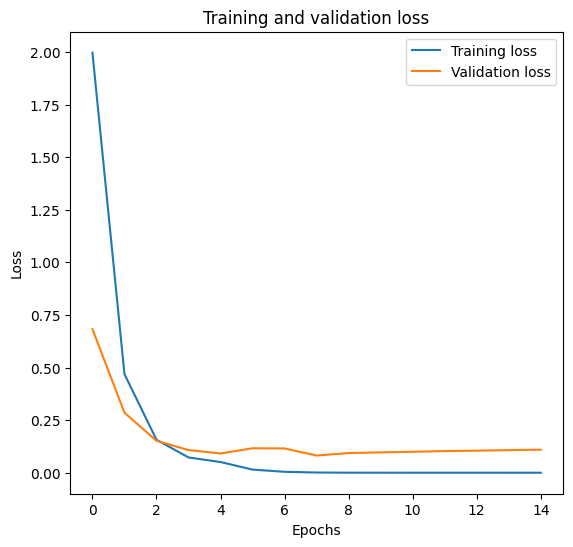

In [153]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The test accuracy looks very good 0.9725274443626404 but the loss number are disastrous. loss: 6.6123e-05 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9890

It looks like there is some overfitting going on on the plot because the training loss is decreasing but the validation loss is increasing.
We can see at that after the 8th epoc the loss is starting to increase alot and the accuracy is 100% which means it is highly overfitted.
To try and fix this we can try some regularization techniques like early stopping and l2 regularization. We can also decrease the number of 
epochs since it is obviously bad for the model to keep on training after a while.

In [158]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Create a Sequential model
model11 = Sequential()

# Add Convolutional layers with L2 regularization
model11.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(64, 64, 1)))
model11.add(MaxPooling2D((2, 2)))

model11.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model11.add(MaxPooling2D((2, 2)))

model11.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model11.add(MaxPooling2D((2, 2)))

model11.add(Flatten())

# Add Dense layers with L2 regularization
model11.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model11.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model11.add(Dense(len(letters), activation='softmax'))

# Compile the model with the Adam optimizer and categorical crossentropy loss
model11.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history11 = model11.fit(x_train, y_train, epochs=12, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model11.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/12
46/46 [==============================] - 12s 248ms/step - loss: 9.4265 - accuracy: 0.3444 - val_loss: 3.3185 - val_accuracy: 0.6188
Epoch 2/12
46/46 [==============================] - 11s 236ms/step - loss: 2.3233 - accuracy: 0.7713 - val_loss: 1.8864 - val_accuracy: 0.8398
Epoch 3/12
46/46 [==============================] - 12s 259ms/step - loss: 1.5944 - accuracy: 0.8781 - val_loss: 1.4676 - val_accuracy: 0.8729
Epoch 4/12
46/46 [==============================] - 12s 263ms/step - loss: 1.2607 - accuracy: 0.9105 - val_loss: 1.2993 - val_accuracy: 0.8619
Epoch 5/12
46/46 [==============================] - 12s 252ms/step - loss: 1.1577 - accuracy: 0.9098 - val_loss: 1.1282 - val_accuracy: 0.8785
Epoch 6/12
46/46 [==============================] - 11s 247ms/step - loss: 0.9872 - accuracy: 0.9284 - val_loss: 0.9349 - val_accuracy: 0.9337
Epoch 7/12
46/46 [==============================] - 11s 247ms/step - loss: 0.8494 - accuracy: 0.9545 - val_loss: 0.9683 - val_accuracy: 0.8950

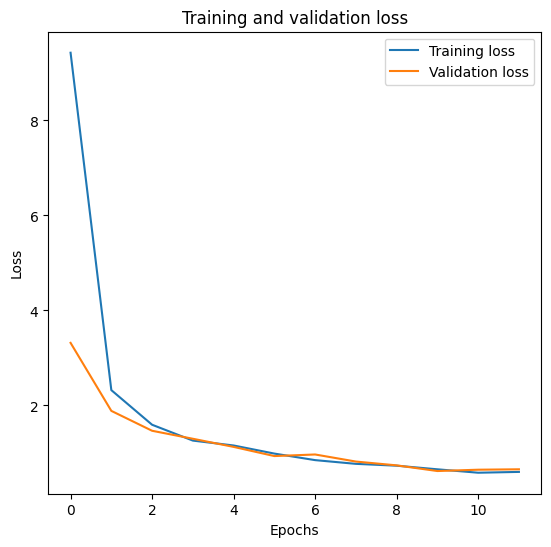

In [160]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='Training loss')
plt.plot(history11.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss: 0.6015 - accuracy: 0.9566 - val_loss: 0.6565 - val_accuracy: 0.9392

Test Accuracy: 0.9450549483299255

Pretty good! The re4gularization worked. No sign of overfitting

Lets make some predictions

1/1 [==============================] - 0s 22ms/step


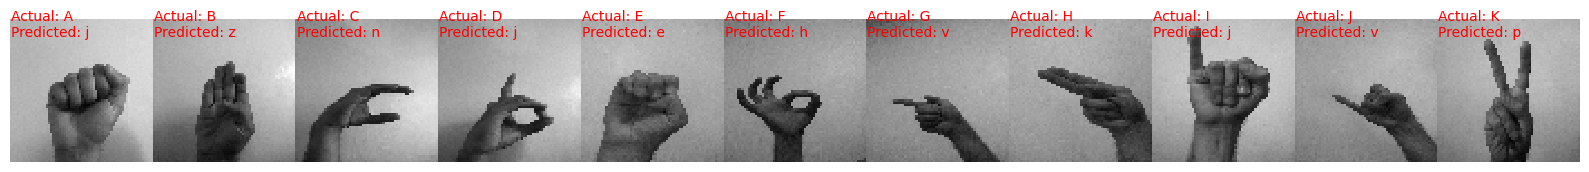

In [161]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model11.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model11, letters)


This is predictions on my own photographs. 1/11 right answers. Thats bad.

Summary :

The accuracy and loss plots looks good. The test accuracy is very good. The model is not overfitting or underfitting but the predictions on my pictures are
not good. Maybe i need som more training data or maybe some augmentation on my pictures. 
I am going to try the other dataset to try and make a better model. I am going to use the same model architecture, same parameters and preprocessing and see what happens.
This new dataset also has A-Z classes but it has 3000 pictures of each of the letters. So now we have 60 times more data than the last dataset.
Lets get to it!

In [206]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define the path to your dataset folder
data_dir = 'Dataset/sign_train'
letters = sorted(os.listdir(data_dir))

# Load and preprocess the images
def load_images(data_dir, letters):
    images = []
    labels = []
    for i, letter in enumerate(letters):
        letter_dir = os.path.join(data_dir, letter)
        for filename in os.listdir(letter_dir):
            img_path = os.path.join(letter_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(i)  # Use index as label
    return np.array(images), np.array(labels)

x_data, y_data = load_images(data_dir, letters)

# Normalize pixel values
x_data = x_data.astype(np.float32) / 255

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, len(letters))

# Split the data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

# Build your model as before
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())

model2.add(Dense(1024, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(len(letters), activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Lets start with 10 epochs and see what happens.

In [207]:
# Train the model
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

# Save the model

model2.save('model2.h5')

Epoch 1/10
975/975 [==============================] - 412s 421ms/step - loss: 0.7093 - accuracy: 0.7752 - val_loss: 0.1177 - val_accuracy: 0.9627
Epoch 2/10
975/975 [==============================] - 418s 429ms/step - loss: 0.0758 - accuracy: 0.9757 - val_loss: 0.0708 - val_accuracy: 0.9814
Epoch 3/10
975/975 [==============================] - 409s 420ms/step - loss: 0.0376 - accuracy: 0.9890 - val_loss: 0.0335 - val_accuracy: 0.9899
Epoch 4/10
975/975 [==============================] - 409s 420ms/step - loss: 0.0487 - accuracy: 0.9860 - val_loss: 0.0118 - val_accuracy: 0.9954
Epoch 5/10
975/975 [==============================] - 409s 419ms/step - loss: 0.0290 - accuracy: 0.9921 - val_loss: 0.0493 - val_accuracy: 0.9877
Epoch 6/10
975/975 [==============================] - 408s 419ms/step - loss: 0.0241 - accuracy: 0.9935 - val_loss: 0.0693 - val_accuracy: 0.9795
Epoch 7/10
975/975 [==============================] - 407s 417ms/step - loss: 0.0190 - accuracy: 0.9950 - val_loss: 0.0561 -

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [208]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

244/244 [==============================] - 13s 53ms/step - loss: 0.0024 - accuracy: 0.9992
Test Accuracy: 0.9992307424545288


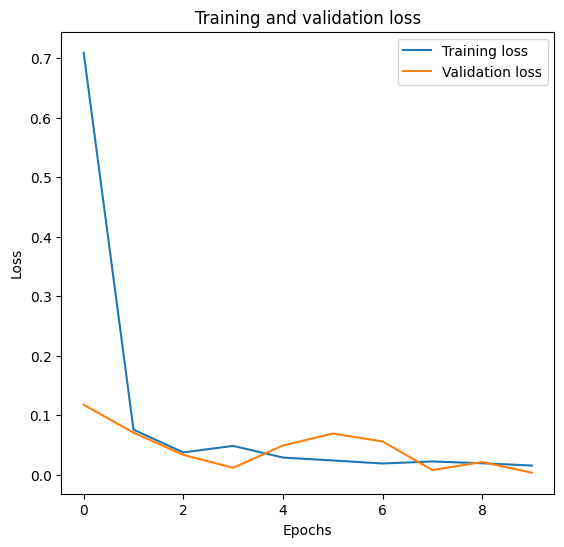

In [209]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 0.9992307424545288

This looks really good. loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0796 - val_accuracy: 0.9767

1/1 [==============================] - 0s 23ms/step


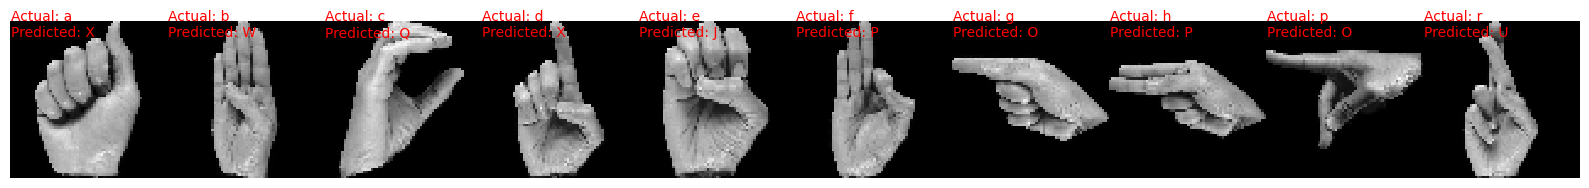

In [210]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation1'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model2.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model2, letters)

1/1 [==============================] - 0s 25ms/step


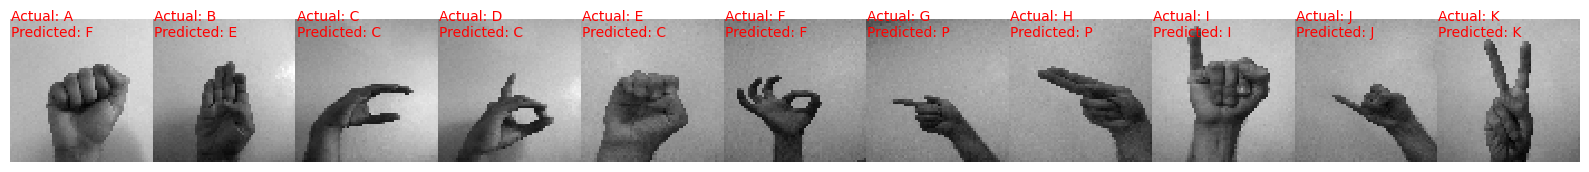

In [211]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model2.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model2, letters)

5/11 right answers. Thats pretty good

In [16]:

model3 = Sequential()

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())

model3.add(Dense(1024, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(len(letters), activation='softmax'))

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history3 = model3.fit(x_train, y_train, epochs=7, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss1, test_accuracy1 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy1}")

# Save the model

model3.save('model3.h5')

Epoch 1/7
975/975 [==============================] - 375s 383ms/step - loss: 0.6862 - accuracy: 0.7814 - val_loss: 0.1439 - val_accuracy: 0.9503
Epoch 2/7
975/975 [==============================] - 375s 384ms/step - loss: 0.0728 - accuracy: 0.9764 - val_loss: 0.0502 - val_accuracy: 0.9840
Epoch 3/7
975/975 [==============================] - 374s 383ms/step - loss: 0.0431 - accuracy: 0.9870 - val_loss: 0.0340 - val_accuracy: 0.9888
Epoch 4/7
975/975 [==============================] - 373s 382ms/step - loss: 0.0319 - accuracy: 0.9909 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 5/7
975/975 [==============================] - 373s 382ms/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.0150 - val_accuracy: 0.9954
Epoch 6/7
975/975 [==============================] - 372s 382ms/step - loss: 0.0275 - accuracy: 0.9923 - val_loss: 0.0382 - val_accuracy: 0.9886
Epoch 7/7
244/244 [==============================] - 12s 50ms/step - loss: 0.0505 - accuracy: 0.9877
Test Accuracy: 0.987692296504

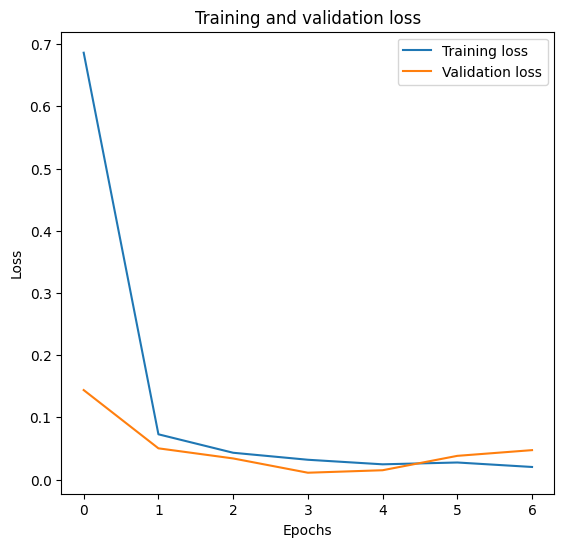

In [18]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss: 0.0204 - accuracy: 0.9947 - val_loss: 0.0056 - val_accuracy: 0.9985

Test Accuracy: 0.998846173286438 This is the best test accuracy so far. 

Lets try some predictions!

1/1 [==============================] - 0s 21ms/step


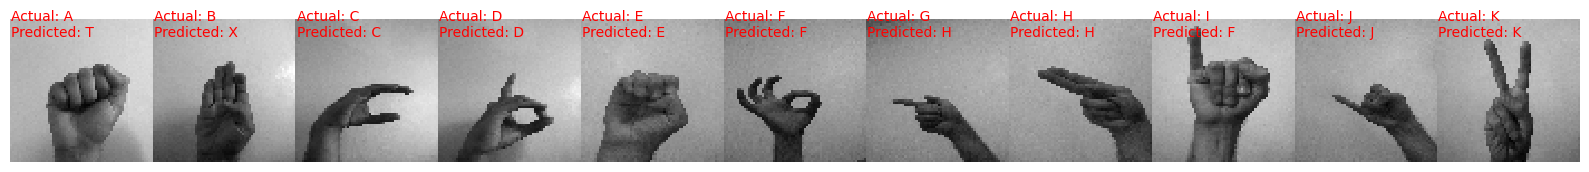

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model3.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model3, letters)

This is actually pretty good. 7/11 right predictions. This is the best model so far!


# Transfer learning

I want to try a pretrained model, save the CNN with weights and biases and then train a new model with the pretrained model as a base.
I am going to use the model VGG16. 

Now I want to try with colours. Before we go and train the model I just want to see the original images versus
the preprocessed images in colour and see how it looks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


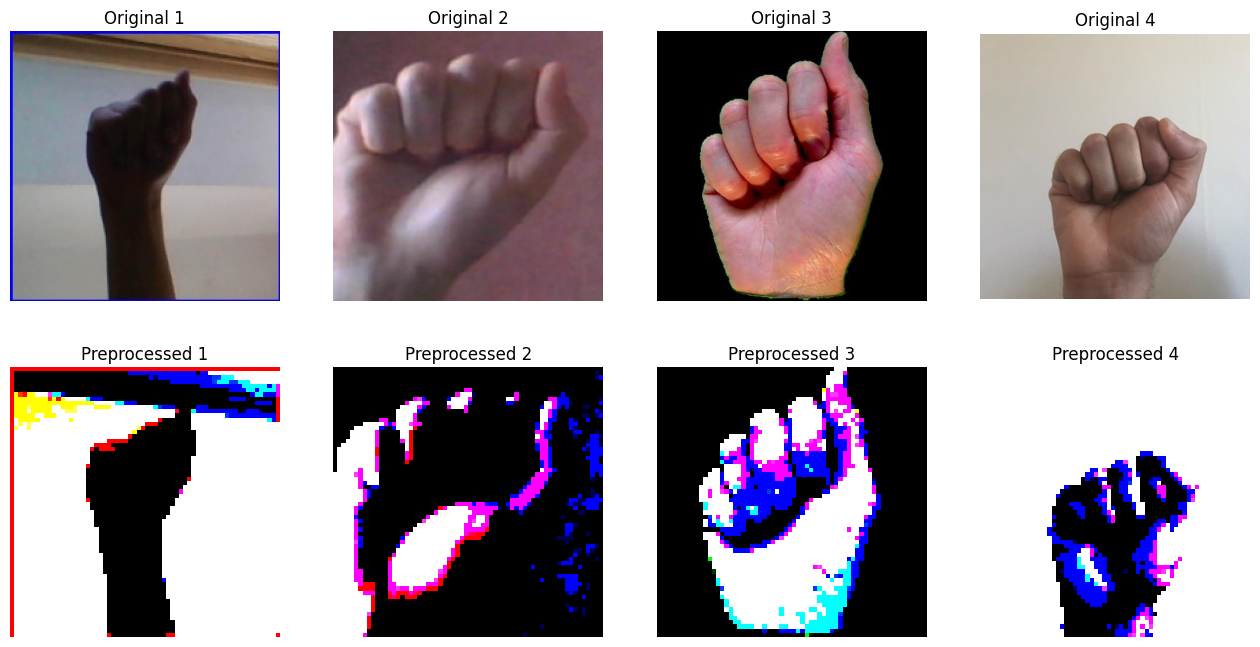

In [21]:

IMG_SIZE = (64, 64)  # Default input size for VGG16
# Specify the path to the "Image_choice" directory containing four pictures
IMAGE_CHOICE_PATH = "Image_choice"

# Get a list of image file names in the directory
image_file_names = os.listdir(IMAGE_CHOICE_PATH)

# Create the full paths to the images
image_paths = [os.path.join(IMAGE_CHOICE_PATH, name) for name in image_file_names]

# Function to preprocess an image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=IMG_SIZE, color_mode='rgb'
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Load and preprocess the original and preprocessed images
original_images = [tf.keras.preprocessing.image.load_img(path) for path in image_paths]
preprocessed_images = [preprocess_image(path) for path in image_paths]

# Create labels for the images
labels = ["Original 1", "Original 2", "Original 3", "Original 4",
          "Preprocessed 1", "Preprocessed 2", "Preprocessed 3", "Preprocessed 4"]

# Plot the images with labels
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(original_images[i] if i < 4 else preprocessed_images[i - 4])
    plt.title(labels[i])
    plt.axis("off")

plt.show()

The first preprocessed picture is not very good. The wooden board in the background becomes very clear and significant when we preprocess the picture and that is not a good thing.
It even blends together with our hand so the filter in our CNN that looks for edges is going to send alot of features we dont want as input to our classification layer.
The thing we are after here is to isolate the hand from everything else and search for a very clean background.

The second picture looks even worse. The lines here is not drawing a complete hand but only parts of it. This is not going to give our model good features for detecting sign lanugage.

The thrid hand is very good. I think this is because the background is artificially made black so it is a very good significant boundary between our hand and the background.

The fourth picture is my own picture and it looks pretty good too. I only have 7 pictures of my own pictures so I am only going to use them as evaluation pictures to make predictions
on with our final model.

I am going to use the third dataset for training, testing and validation. Then I am going to use my own pictures and maybe some other pictures from the other datasets to try and 
make predictions on.


# Preprocessing

The preprocessing is pretty much the same in this one but we have colour in our pictures now. 64x64 pixel, split the data into train, test, validation.
Then we use some augmentation to reduce the chance of overfitting and train on some more pictures

In [175]:

CUSTOM_DATASET_PATH = "Dataset2/asl_dataset"

# Create a list of class names (A-Z)
class_names = sorted(os.listdir(CUSTOM_DATASET_PATH))

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (64, 64)

# Importing the dataset and splitting it into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Add a seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,  # Use the same seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

# Split the validation dataset into validation and test datasets (50% each)
validation_size = len(validation_dataset)
test_size = validation_size // 2
validation_dataset = validation_dataset.skip(test_size)
test_dataset = validation_dataset.take(test_size)

# Create an ImageDataGenerator for data augmentation
datagen = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

# Apply data augmentation to the training dataset
augmented_train_dataset = train_dataset.map(lambda x, y: (datagen(x, training=True), y))

# Create the base model VGG16 with pre-trained weights (include_top=False for feature extraction)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SIZE + (3,),  # Input shape with 3 channels (RGB)
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the final model by chaining layers
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),  # Input shape for RGB images
    datagen,
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Found 1815 files belonging to 26 classes.
Using 1452 files for training.
Found 1815 files belonging to 26 classes.
Using 363 files for validation.


In [176]:
# Train the model
epochs = 10

history4 = model4.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

# Save the trained model to a file
model4.save("trained_model.h5")


Epoch 1/10
46/46 [==============================] - 18s 363ms/step - loss: 11.6032 - accuracy: 0.0675 - val_loss: 11.3734 - val_accuracy: 0.1228
Epoch 2/10
46/46 [==============================] - 17s 374ms/step - loss: 6.5683 - accuracy: 0.1970 - val_loss: 7.4427 - val_accuracy: 0.2222
Epoch 3/10
46/46 [==============================] - 18s 386ms/step - loss: 4.3588 - accuracy: 0.3154 - val_loss: 5.7684 - val_accuracy: 0.3041
Epoch 4/10
46/46 [==============================] - 18s 392ms/step - loss: 3.4144 - accuracy: 0.3933 - val_loss: 5.1741 - val_accuracy: 0.3392
Epoch 5/10
46/46 [==============================] - 18s 397ms/step - loss: 2.8469 - accuracy: 0.4360 - val_loss: 4.1548 - val_accuracy: 0.3918
Epoch 6/10
46/46 [==============================] - 19s 402ms/step - loss: 2.3714 - accuracy: 0.4848 - val_loss: 4.2211 - val_accuracy: 0.4327
Epoch 7/10
46/46 [==============================] - 19s 406ms/step - loss: 2.3726 - accuracy: 0.5165 - val_loss: 3.4198 - val_accuracy: 0.42

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [184]:
test_loss, test_accuracy = model4.evaluate(test_dataset)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

6/6 [==============================] - 2s 302ms/step - loss: 1.5520 - accuracy: 0.6608
Test accuracy: 66.08%


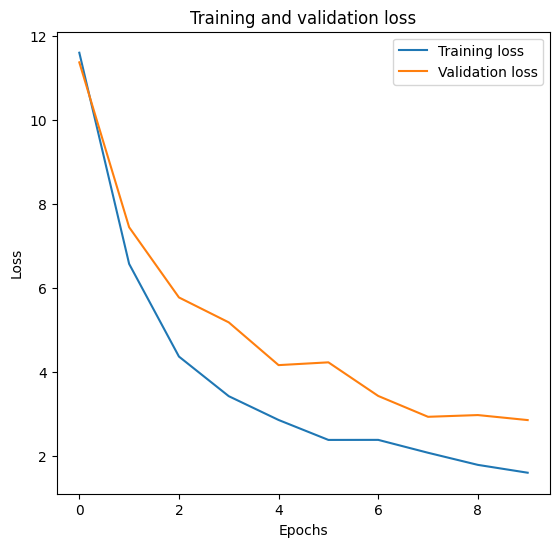

In [178]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Well this was a disappointment. The model looks like its overfitted. I suspect that there is something wrong with the augmentation.

Lets look at some random pictures from the dataset when they are augmented.

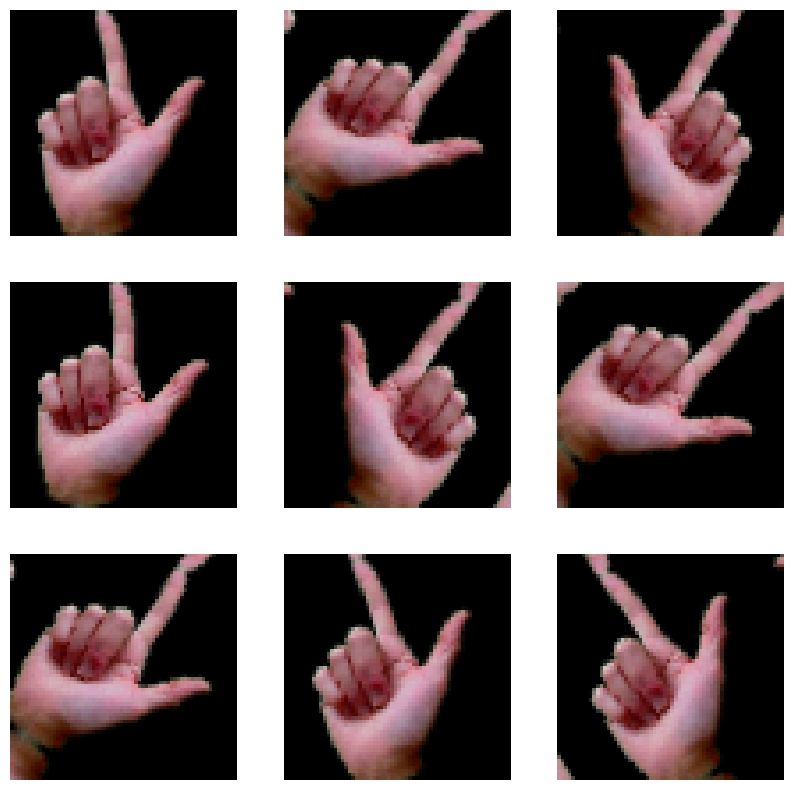

In [35]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

These pictures doesnt look good. You see the forefinger is moving out the frame and meeting the same mirrored finger. I realize this ploting a few of these pictures that this
is going to be a problem. The features is going to be very inaccurate in predicting features in my other datasets. I decide that I am going to scratch the idea of augmentation.
And also when I flip the picture some signs are going to look like another sign but be labeled as the first one. So for example the sign for I is very much like the mirror image 
of the sign of L.

Maybe its the colour that is making all this noise. Lets look at a few random pictures both with and without colours

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


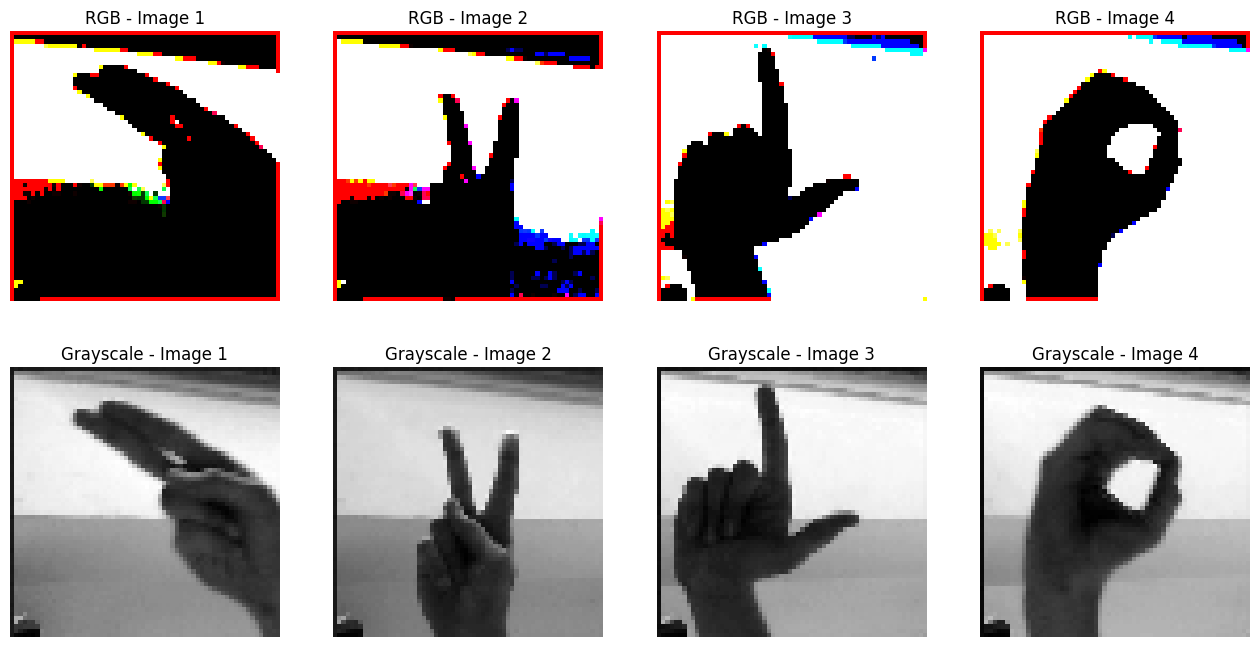

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

IMG_SIZE = (64, 64)


# Path to the directory containing your example images
EXAMPLE_PATH = "Dataset3/Example"

# Create a list of example image file names
example_images = os.listdir(EXAMPLE_PATH)[:4]  # Get the first four images

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, img_size, color_mode):
    img = image.load_img(image_path, target_size=img_size, color_mode=color_mode)
    img_array = image.img_to_array(img)
    
    if color_mode == 'rgb':
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Preprocess for VGG16
    elif color_mode == 'grayscale':
        img_array /= 255.0  # Normalize pixel values to [0, 1] for grayscale images
    
    return img_array

# Create subplots for displaying RGB and grayscale images
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Loop through example images and plot both RGB and grayscale versions
for i, image_name in enumerate(example_images):
    image_path = os.path.join(EXAMPLE_PATH, image_name)
    
    # Load and preprocess RGB image
    rgb_image = load_and_preprocess_image(image_path, IMG_SIZE, 'rgb')
    
    # Load and preprocess grayscale image
    grayscale_image = load_and_preprocess_image(image_path, IMG_SIZE, 'grayscale')
    
    # Plot RGB image
    axs[0, i].imshow(rgb_image)
    axs[0, i].set_title(f"RGB - Image {i + 1}")
    axs[0, i].axis('off')
    
    # Plot grayscale image
    axs[1, i].imshow(grayscale_image.squeeze(), cmap='gray')
    axs[1, i].set_title(f"Grayscale - Image {i + 1}")
    axs[1, i].axis('off')

plt.show()


Just as I thought! The darker part of the first two coloured pictures gets the exact same pixel-colour-value as the hand so they both get pitch black and blends together.
The greyscale pictures is much better. 

If I am going to train the model with this dataset again I am going to do it without the rotating part of the augmentation.

Lets skip colours and just go greyscale!

In [200]:

# Specify the path to your custom dataset directory
CUSTOM_DATASET_PATH = "Dataset2/asl_dataset"

# Create a list of class names (A-Z)
class_names = sorted(os.listdir(CUSTOM_DATASET_PATH))

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Importing the dataset and splitting it into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Add a seed for consistent data split
    color_mode="grayscale"  # Load images as grayscale
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,  # Use the same seed for consistent data split
    color_mode="grayscale"  # Load images as grayscale
)

# Define a function to duplicate grayscale images to RGB
def duplicate_channels(images, labels):
    images = tf.tile(images, [1, 1, 1, 3])  # Duplicate the single channel to three channels
    return images, labels

# Apply the channel duplication function to the datasets
train_dataset = train_dataset.map(duplicate_channels)
validation_dataset = validation_dataset.map(duplicate_channels)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Create the base model VGG16 without the top classification layers and custom weights
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SIZE + (3,),  # Input shape with 3 channels (RGB)
    include_top=False,
    weights=None  # Do not load pre-trained weights
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the final model by chaining layers
modelo = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),  # Input shape for RGB images
    data_augmentation,
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define a learning rate schedule (you can customize this)
def learning_rate_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Define callbacks for early stopping and model checkpointing
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Define a learning rate scheduler callback
learning_rate_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)


Found 1815 files belonging to 26 classes.
Using 1452 files for training.
Found 1815 files belonging to 26 classes.
Using 363 files for validation.


In [201]:
# Train the model
epochs = 10

historyo = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, model_checkpoint_callback, learning_rate_scheduler_callback]
)

# Save the trained model to a file
modelo.save("trained_model.h5")

Epoch 1/10


46/46 [==============================] - ETA: 0s - loss: 3.2755 - accuracy: 0.0372

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 275s 6s/step - loss: 3.2755 - accuracy: 0.0372 - val_loss: 3.2662 - val_accuracy: 0.0386 - lr: 0.0010
Epoch 2/10
46/46 [==============================] - 295s 6s/step - loss: 3.2533 - accuracy: 0.0379 - val_loss: 3.2298 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 3/10
46/46 [==============================] - 281s 6s/step - loss: 3.2339 - accuracy: 0.0468 - val_loss: 3.2050 - val_accuracy: 0.0496 - lr: 0.0010
Epoch 4/10
46/46 [==============================] - 279s 6s/step - loss: 3.2194 - accuracy: 0.0647 - val_loss: 3.1943 - val_accuracy: 0.0799 - lr: 0.0010
Epoch 5/10
46/46 [==============================] - 273s 6s/step - loss: 3.2056 - accuracy: 0.0592 - val_loss: 3.1813 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 6/10
46/46 [==============================] - 276s 6s/step - loss: 3.1929 - accuracy: 0.0792 - val_loss: 3.1522 - val_accuracy: 0.0716 - lr: 0.0010
Epoch 7/10
46/46 [==============================] - 283s 6s/step - loss: 3.1761 - accur

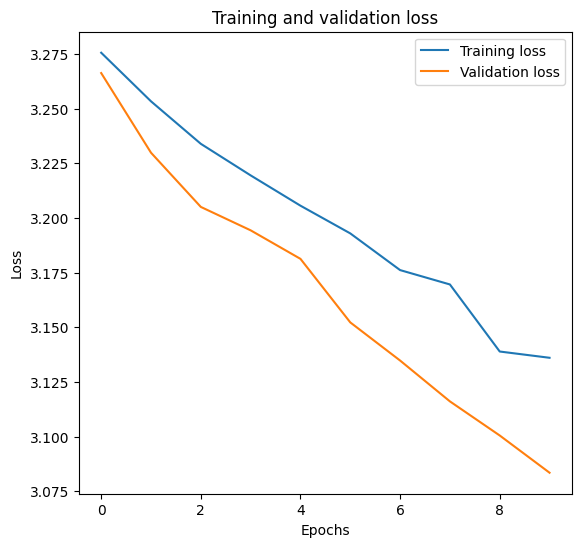

In [203]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(historyo.history['loss'], label='Training loss')
plt.plot(historyo.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This too looks overfitted. The validation loss is lower than the training loss.

Lets try one last model with the other dataset.

In [129]:
CUSTOM_DATASET_PATH = "Dataset/sign_train"

# Create a list of class names (A-Z)
class_names = sorted(os.listdir(CUSTOM_DATASET_PATH))

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

# Importing the dataset and splitting it into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Add a seed for consistent data split
    color_mode="grayscale"  # Load images as grayscale
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,  # Use the same seed for consistent data split
    color_mode="grayscale"  # Load images as grayscale
)

# Define a function to duplicate grayscale images to RGB
def duplicate_channels(images, labels):
    images = tf.tile(images, [1, 1, 1, 3])  # Duplicate the single channel to three channels
    return images, labels

# Apply the channel duplication function to the datasets
train_dataset = train_dataset.map(duplicate_channels)
validation_dataset = validation_dataset.map(duplicate_channels)
test_dataset = test_dataset.map(duplicate_channels)


# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Create the base model VGG16 with pre-trained weights (include_top=False for feature extraction)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SIZE + (3,),  # Input shape with 3 channels (RGB)
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the final model by chaining layers
model42 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),  # Input shape for RGB images
    data_augmentation,
    base_model,
    global_average_layer,
    prediction_layer
])

# Define a learning rate schedule (you can customize this)
def learning_rate_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Compile the model with an initial learning rate
initial_learning_rate = 0.001
model42.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define callbacks for early stopping and model checkpointing
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Define a learning rate scheduler callback
learning_rate_scheduler_callback = LearningRateScheduler(learning_rate_schedule)




Found 78000 files belonging to 26 classes.
Using 62400 files for training.
Found 78000 files belonging to 26 classes.
Using 15600 files for validation.


In [131]:
# Train the model with callbacks
historien = model42.fit(train_dataset,
                    epochs=10,  # Adjust the number of epochs as needed
                    validation_data=validation_dataset,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, learning_rate_scheduler_callback])

Epoch 1/10


1950/1950 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.7652

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1950/1950 [==============================] - 3778s 2s/step - loss: 0.9587 - accuracy: 0.7652 - val_loss: 0.3280 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 2/10
1950/1950 [==============================] - 3669s 2s/step - loss: 0.2641 - accuracy: 0.9146 - val_loss: 0.2083 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 3/10
1950/1950 [==============================] - 3664s 2s/step - loss: 0.2120 - accuracy: 0.9306 - val_loss: 0.2297 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 4/10
1950/1950 [==============================] - 3678s 2s/step - loss: 0.1880 - accuracy: 0.9394 - val_loss: 0.1834 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 5/10
1950/1950 [==============================] - 3654s 2s/step - loss: 0.1758 - accuracy: 0.9424 - val_loss: 0.1774 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 6/10
1950/1950 [==============================] - 3663s 2s/step - loss: 0.1678 - accuracy: 0.9466 - val_loss: 0.1490 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 7/10
1950/1950 [==============================] - 3

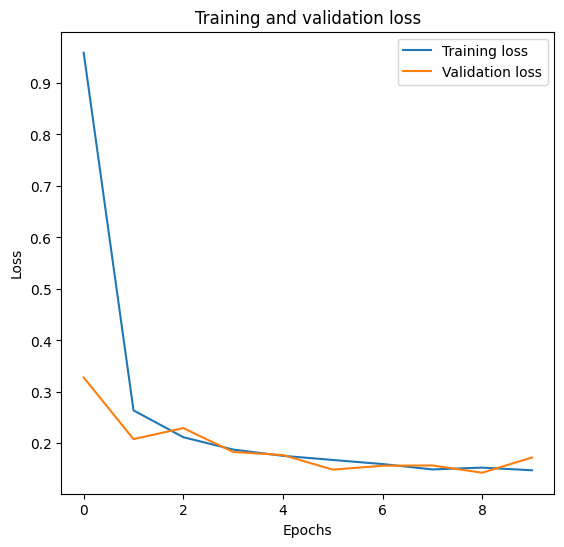

In [133]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(historien.history['loss'], label='Training loss')
plt.plot(historien.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss: 0.1478 - accuracy: 0.9533 - val_loss: 0.1726 - val_accuracy: 0.9429 - lr: 0.0010

This was way better! No overfitting and low loss. Lets predict!

1/1 [==============================] - 0s 71ms/step


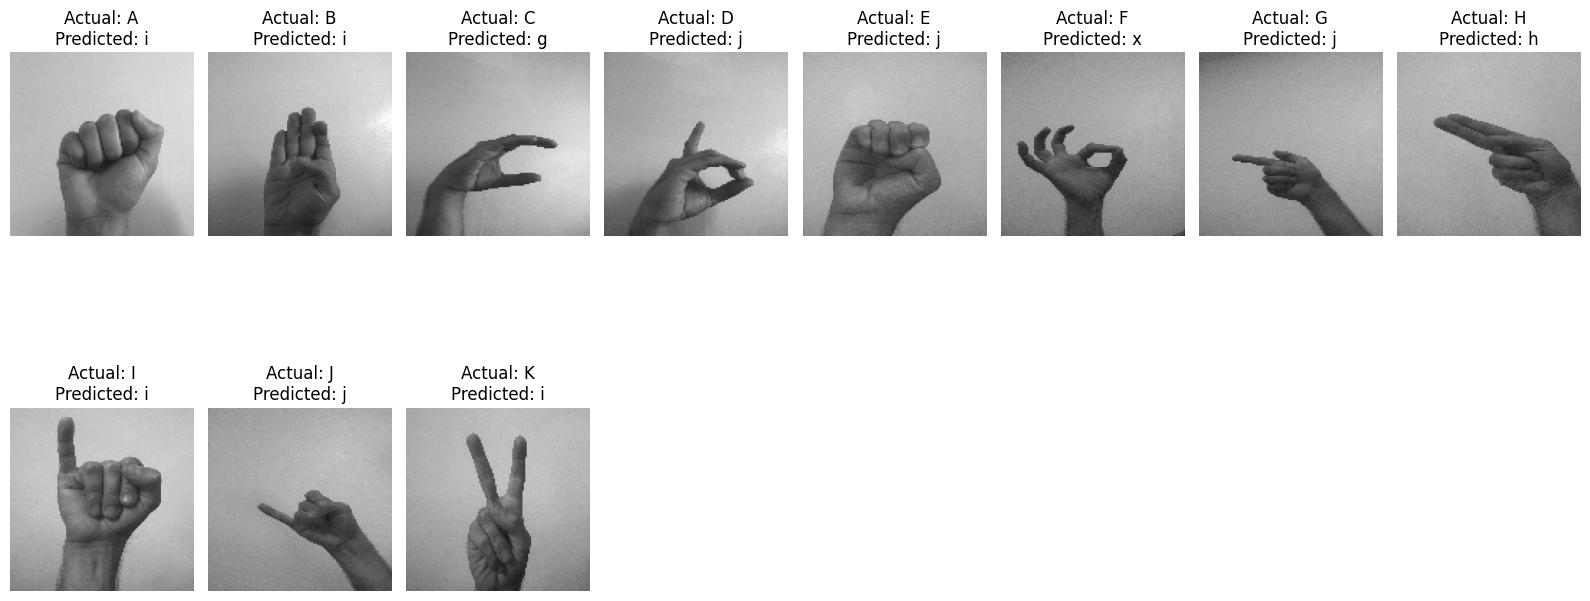

In [205]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters, rows=8, image_size=(128, 128)):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))
    num_classes = len(class_folders)

    num_images_per_row = min(rows, num_classes)
    num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

    plt.figure(figsize=(16, 4 * num_rows))

    for row in range(num_rows):
        plt.subplot(num_rows, num_images_per_row, row * num_images_per_row + 1)
        plt.axis('off')

        for i in range(num_images_per_row):
            class_idx = row * num_images_per_row + i

            if class_idx >= num_classes:
                break

            folder = class_folders[class_idx]
            class_path = os.path.join(image_dir, folder)
            image_files = os.listdir(class_path)

            image_file = image_files[0]  # Only take the first image for simplicity

            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=image_size)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # Duplicate the single grayscale channel to three channels (RGB)
            img_array = np.concatenate([img_array] * 3, axis=-1)

            actual_class = folder
            predicted_class = letters[np.argmax(model42.predict(img_array))]

            plt.subplot(num_rows, num_images_per_row, row * num_images_per_row + i + 1)
            plt.imshow(img_array[0])
            plt.axis('off')
            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    plt.tight_layout()
    plt.show()

# Interact with the user and display images in rows of 8 with labels
interact_with_user(model42, letters)

3/11 right answers. Better than nothing.

# Reflection

## The dataset

I realized how important it is to view and evaluate the pictures in the dataset before even considering using them.
Depending on what you want to do you have to really think about how difficult it is going to be to get relevant
features out of it. Here I wanted something very simple : 

A one coloured background
As few shadows as possible
Every sign from an angle where it really made that sign unique in realtion to the others

This could be easily achieved by drawing pictures in paint. Then you could arrange the whole picture yourself.
But that would mean that it would be customized for this particular model for this specific task. I wanted to
try to build a more generalized model that could predict sign lanugage in other datasets. I wanted to work with
pictures instead of digital art 

## The preprocessing

There was a huge difference for the model to learning to generalize depending how the pictures were preprocessed.
We could see on the plot where I compared 64x64 and the 32x32 that there was a huge dirrence in how the lines 
around the hand was drawn. The 64x64 was way smoother and sharper than the 32x32 ones.
The coloured images became way more complex to generalize. There we could see on the photos that things in
the background became way more visible than before the preprocessing and the brightness of the whole picture
was traded for a much darker picture. The shadows in the hand ruined the whole picture by making the shadows in
the hand blend together with the background and making it impossible for the CNN filter to find good features
that represented a hand at all. 

## The model

First Im building some simple models myself with eight layers, three convolutional layers (64, 128, and 256 filters), three max pooling layers and two Dense layers. 
Those models got pretty hight test accuracy, no overfitting and quite low loss. 

## First model : 

Iamge size : 64x64

0.16: loss

accuracy: 0.9986 

val_loss: 0.0393

val_accuracy: 0.9890

test_accuracy :0.9670329689979553

Accurate predictions on my own pictures : 0/11

## Second model

loss: 0.014

accuracy: 0.99

val_loss: 0.07

val_accuracy: 0.97

Test_accuracy : 0.97

Accurate predictions on my own pictures : 7/11

## Third model with VGG16 :

Image size : 224x224

loss: 0.7591

accuracy: 0.7996

val_loss: 0.8668

val_accuracy: 0.7661

test_accuracy : 0.69

Accurate predictions on my own pictures : 0/11

## Fourth model with VGG16:

Image size : 128x128

loss: 1.3860

accuracy: 0.6796

val_loss: 1.9718

val_accuracy: 0.6431

test_accuracy : 0.64


So my second model was the best. I dont know why though. The VGG16 should've delivered some good results.
Maybe I didnt use it the right way I dont know. I have tested it on binary classification and it is amazing
but here on multi classification it just didnt make it.


# Summary

This was a very fun project. You can sit and tewak with this models day in and day out. 
You get a alot of ideas when you figure out more and more how it works and what you can
do with it. When it works and goes your way the possibilities seems endless but when
things dont work out as you would imagine it in your head the possibilites seems very
slim.

If I could do this project again i would spend alot of more time searching for a good 
dataset and evaluating the datasets before deciding. 


